<strong>Aluno</strong>: Victor São Paulo Ruela



In [31]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from IPython.display import clear_output


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Implementação do perceptron simples para um problema de classificação binário
class LinearPerceptron:
    def __init__(self, eta=0.01, max_epochs=100):
        self.eta = eta
        self.max_epochs = max_epochs

    def predict(self, x, w):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        u = x_aug @ w
        return np.sign(u)

    def train(self, x_train, y_train):
        # initialize the weight matrix
        N, n = x_train.shape
        x_aug = np.hstack((-np.ones((N, 1)), x_train))

        wt = np.random.rand(n+1) - 0.5
        n_epochs = 0

        while(n_epochs < self.max_epochs):
            # generate random indexes order
            xseq = np.arange(N)
            np.random.shuffle(xseq)

            for i_rand in xseq:
                yhati = np.sign(x_aug[i_rand, :] @ wt)
                ei = y_train[i_rand] - yhati
                # calculate step size
                dw = self.eta * ei * x_aug[i_rand, :]
                # update weight vector
                wt = wt + dw
            # increment number of epochs
            n_epochs = n_epochs + 1

        return wt

# Implementação do perceptron simples para um problema de classificação binário
class ELM:
    def __init__(self, p=5):
        self.p = p

    def predict(self, x, w, H, Z):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        H = np.tanh(x_aug @ Z)
        u = np.sign(H @ w)
        return u

    def train(self, x_train, y_train):
        N, n = x_train.shape
        # augment X
        x_aug = np.hstack((-np.ones((N, 1)), x_train))
        # create initial Z matrix
        Z = np.random.uniform(-0.5, 0.5, (n+1, self.p))
        # apply activation function: tanh
        H = np.tanh(x_aug @ Z)
        # calculate the weights
        w = np.linalg.pinv(H) @ y_train
        return w, H, Z

In [3]:
# load the breast cancer data
X_bc, y_bc = load_breast_cancer(return_X_y = True)
# convert the classes to -1 or 1
y_bc = pd.Series(y_bc).map({0:-1,1:1}).to_numpy()
# scale the data
scaler_bc = MinMaxScaler()
X_bc = scaler_bc.fit_transform(X_bc)

In [4]:
# load the statlog(heart) dataset
heart_df = pd.read_csv('heart.dat', sep=' ', header=None)
X_hd, y_hd = heart_df.iloc[:,:-1].to_numpy(), heart_df.iloc[:,-1].map({2:1, 1:-1}).to_numpy()
# scale the data
scaler_hd = MinMaxScaler()
X_hd = scaler_hd.fit_transform(X_hd)

In [5]:
# split the data
def train_test_split(X, y, ratio=0.7):
    N = len(y)
    x_rand = np.arange(N)
    np.random.shuffle(x_rand)
    i_split = int(np.floor(ratio * N))

    x_train, x_test = x_rand[:i_split], x_rand[i_split:]
    return X[x_train,:], y[x_train], X[x_test,:], y[x_test]

def calculate_accuracy(y, yhat):
    return 100 * np.sum(y == yhat)/len(yhat)

def elm_experiment_multiple_neurons(X_train, y_train, X_test, y_test, neurons, reps=10):
    accuracy_results = []
    accuracy_results_train = []
    for p in neurons:
        model = ELM(p=p)
        accuracy_test = []
        accuracy_train = []
        for rep in range(reps):
            # train the model on training set
            w, H, Z = model.train(X_train, y_train)
            # make predictions for the teste set
            yhat = model.predict(X_test, w, H, Z)
            yhat_train = model.predict(X_train, w, H, Z)
            # accuracy
            accuracy_test.append(calculate_accuracy(y_test, yhat))
            accuracy_train.append(calculate_accuracy(y_train, yhat_train))
            
        accuracy_results.append(np.mean(accuracy_test))
        accuracy_results_train.append(np.mean(accuracy_train))

    return accuracy_results, accuracy_results_train

def elm_experiment_dataset_split(X, y, N=30, neurons=[5,10,30,50,100,300], plot=True):
    experiment_values_test = []
    experiment_values_train = []
    data_sets = {}
    for i in range(N):
        # split the data
        X_train, y_train, X_test, y_test = train_test_split(X, y)
        data_sets[i] = (X_train, y_train, X_test, y_test)
        # run for every neuron
        test_values, train_values = elm_experiment_multiple_neurons(X_train, y_train, X_test, y_test, neurons)

        experiment_values_test.append(test_values)
        experiment_values_train.append(train_values)

    def convert_results(res, set): 
        df = pd.DataFrame(res, columns=neurons).melt(value_vars=neurons,value_name='Acurácia', var_name='Neurônios')
        df['Conjunto'] = set
        return df

    train_values_df = convert_results(experiment_values_train, 'Treino')
    test_values_df = convert_results(experiment_values_test, 'Teste')
    
    experiment_values_df = pd.concat([train_values_df, test_values_df], ignore_index=True)
    if (plot==True):
        # Plot the accuracy boxplots
        plt.figure(figsize=(10,6))
        sns.boxplot(data=experiment_values_df, x='Conjunto',y='Acurácia', hue='Neurônios', showfliers=False)

        # # Print the results table
        display('Tabela: Acurácia Média e Desvio Padrão')
        display(experiment_values_df.groupby(['Neurônios','Conjunto'])['Acurácia'].agg([np.mean, np.std]))

    return experiment_values_df, data_sets 

## Parte 1: Base de dados Breast Cancer (Diagnostic)

Para este exercício será feita uma análise do algoritmo ELM para treinamento de RNAs. O objetivo é avaliar o impacto do número de nerônios na sua capacidade de generalização, a partir do seguinte experimento:

Nº de neurônios: $[5,10,30,50,100,300]$

* 1) Separar o conjunto de testes entre treinamento 
* 2) Para cada quantidade de neurônios na lista, treinar o ELM 10 vezes
    * 2.1) Isso é necessário por causa da aleatoridade da matriz de projeção
* 3) Salvar a acurácia média de treinamento e testes
* 4) Repetir os passos 1-3 30 vezes.

Uma rotina foi criada para a execução deste experimento, cujos resultados são exibidos abaixo no gráfico boxplot e tabela com a média e desvio padrão obtidos para a acurácia.

'Tabela: Acurácia Média e Desvio Padrão'

mean       std
Neurônios Conjunto                     
5         Teste     86.744639  2.300924
          Treino    87.483250  1.896302
10        Teste     93.399610  1.582024
          Treino    94.237856  0.690599
30        Teste     95.645224  1.244878
          Treino    97.079564  0.415101
50        Teste     95.586745  1.101543
          Treino    97.669179  0.377530
100       Teste     95.177388  1.174193
          Treino    98.504188  0.307847
300       Teste     83.569201  1.438733
          Treino    99.971524  0.030761

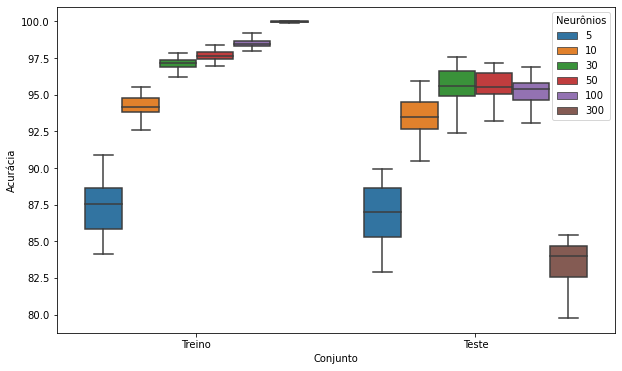

In [6]:
results_bc, datasets_bc = elm_experiment_dataset_split(X_bc, y_bc,neurons=[5,10,30,50,100,300])

A partir dos resultados acima, é possível concluir que:

* A acurácia média de treinamento cresce proporcionalmente com o número de neurônios. Entretanto, se observamos a acurácia de teste, é possível notar que acima de 50 neurônios começa a ocorrer o fenômeno de over-fitting. 
* Note que para 300 neurônios temos uma acurácia de treino de praticamente 100%, porém esta atinge um valor inferior se considerarmos uma quantidade de 10 neurônios, por exemplo.
* Claramente a quantidade de neurônios é um fator a ser controlado como forma de se garantir uma boa generalização com ELMs
* Nota-se que a acurácia de teste chega ao seu máximo considerando uma quantidade de 30 a 50 neurônios.


## Parte 2: Base Statlog (Heart)

A mesma análise anterior é feita considerando a base de dados Statlog (Heart). O mesmo experimento é executado, considerando a rotina desenvolvida anteriormente. Os resultados são exibidos e analisados abaixo.

'Tabela: Acurácia Média e Desvio Padrão'

mean       std
Neurônios Conjunto                      
5         Teste      73.156379  3.273863
          Treino     75.248677  1.981633
10        Teste      79.576132  3.205729
          Treino     82.735450  1.312763
30        Teste      80.415638  3.064886
          Treino     88.075838  1.421118
50        Teste      78.041152  3.050146
          Treino     90.398589  1.372973
100       Teste      72.847737  3.205934
          Treino     96.215168  0.836089
300       Teste      63.674897  3.398320
          Treino    100.000000  0.000000

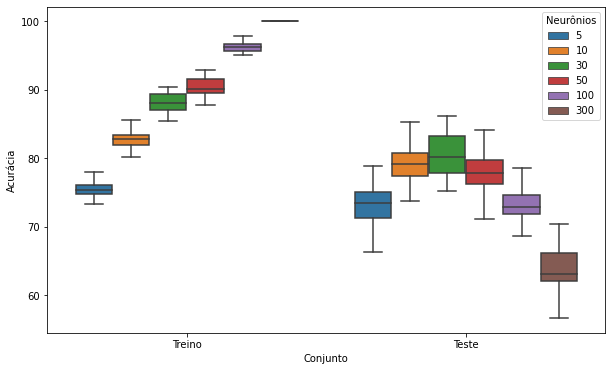

In [7]:
results_hd, datasets_hd = elm_experiment_dataset_split(X_hd, y_hd,neurons=[5,10,30,50,100,300])

A partir dos resultados acima, é possível concluir que:

* Os resultados são bem similares aos encontrados para a base de dados anterior: a acurácia média de treinamento cresce proporcionalmente com o número de neurônios, porém a acurácia de teste começa a reduzir com aproximadamente 30 neurônios.
* Nota-se que a acurácia de teste chega ao seu máximo considerando uma quantidade em torno de 30 neurônios. 
* Mais uma vez, fica claro que a quantidade de neurônios é um fator importante para se obter uma boa generalização com ELMs.

## Parte 3: Comparação com o Perceptron

Um experimento similiar ao anterior é desenvolvido a seguir para avaliar o algoritmo Perceptron:

* 1) Separar o conjunto de testes entre treinamento 
* 2) Treinar o Perceptron 5 vezes
    * 2.1) Isso é necessário por causa do aprendizado com gradiente estocástico
* 3) Salvar a acurácia média de treinamento e testes

Um número máximo de 100 épocas de treinamento será utilizada. Serão considerados os mesmos conjuntos de dados utilizados em cada repetição do experimento do ELM, de forma a se ter uma comparação mais justa entre os algoritmos.


In [37]:
def perceptron_experiment(data_sets, N=5, plot=True):
    model = LinearPerceptron(max_epochs=100)
    accuracy_results_train = []
    accuracy_results_test = []
    
    for ds in tqdm(data_sets.values()):
        X_train, y_train, X_test, y_test = ds
        accuracy_test = []
        accuracy_train = []
        for i in tqdm(range(N)):
            # train the model on training set
            w = model.train(X_train, y_train)
            # make predictions for the teste set
            yhat = model.predict(X_test, w)
            yhat_train = model.predict(X_train, w)

            accuracy_test.append(calculate_accuracy(y_test, yhat))
            accuracy_train.append(calculate_accuracy(y_train, yhat_train))

        # accuracy
        accuracy_results_test.append(np.mean(accuracy_test))
        accuracy_results_train.append(np.mean(accuracy_train))

    def convert_results(res, set): 
        df = pd.DataFrame(res, columns=['Acurácia'])
        df['Conjunto'] = set
        return df

    train_values_df = convert_results(accuracy_results_train, 'Treino')
    test_values_df = convert_results(accuracy_results_test, 'Teste')
    
    experiment_values_df = pd.concat([train_values_df, test_values_df], ignore_index=True)
    # Clears output
    clear_output(wait=True)
    if (plot==True):
        # Plot the accuracy boxplots
        plt.figure(figsize=(8,4))
        sns.boxplot(data=experiment_values_df, x='Conjunto',y='Acurácia', showfliers=False)

        # Print the results table
        display('Tabela: Acurácia Média e Desvio Padrão')
        display(experiment_values_df.groupby('Conjunto')['Acurácia'].agg([np.mean, np.std]))

### Breast Cancer

Os resultados para o experimento são exibidos abaixo. Nota-se que o Perceptron teve um excelente desempenho para esta base de dados, obtendo uma acurácia média acima de 95% para os conjuntos de teste e treinamento. Isso mostra que um modelo linear possui uma excelente capacidade de generalização para este problema. O ELM foi capaz de obter resultados similares com 30 a 50 neurônios.



'Tabela: Acurácia Média e Desvio Padrão'

,mean,std
Conjunto,,
Teste,95.867446,1.229494
Treino,97.499162,0.958795


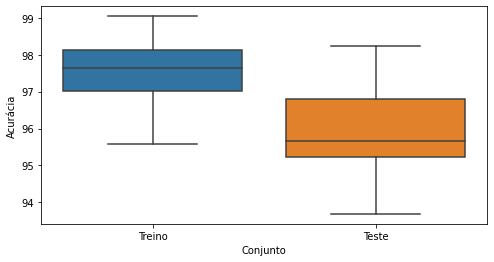

In [41]:
perceptron_experiment(datasets_bc)

### Statlog (Heart)

Os resultados para o experimento são exibidos abaixo. Nota-se que o Perceptron teve um desempenho relativamente bom para esta base de dados, obtendo uma acurácia média acima de 75% para os conjuntos de teste e treinamento. O ELM foi capaz de obter resultados similares com cerca de 30 neurônios. 



'Tabela: Acurácia Média e Desvio Padrão'

,mean,std
Conjunto,,
Teste,77.679012,3.002153
Treino,80.578483,2.730576


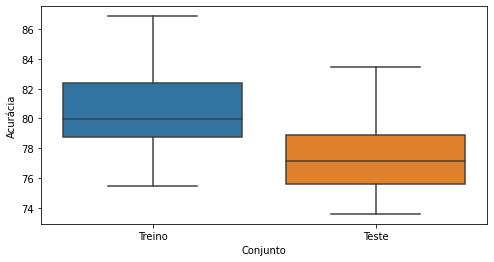

In [42]:
perceptron_experiment(datasets_hd)

## Conclusões

Por meio dos experimentos realizados neste exercício, foi possível constatar que ELMs são capazes de obter um bom desempenho nas bases de dados avaliadas. Entretanto, é importante notar que a escolha da quantidade de neurônios é um hiper-parâmetro que deve ser bem escolhido para se conseguir obter uma boa generalização. Os resultados mostram que o aumento da quantidade de neurônios irá levar ao over-fitting deste modelo. 

Outro resultado importante foi que o Perceptron, embora seja um modelo mais simples, foi capaz de obter resultados similares ao do ELM, com a vantagem de não necessitar do ajuste de nenhum hiper-parâmetro para obter uma boa generalização. Vale a pena ressaltar que as bases de dados consideradas são linermente separáveis, de forma que não podemos extrapolar este resultado para problemas que não possuem esta característica.